# Comparison Between Confidence-Vector and Label-Only MIAs

### Threat Model:

- **Black Box** access to an overfitted classifier with no access to actual $D_{target}$
- Predict API returns **confidence vectors** (1st case) or **only labels instead of confidence vectors** (2nd case)
- We have some insight on the training data distribution, so the attacker will train on $D_{attacker}$ , **but** $D_{target} \cap D_{attacker} = \varnothing$
- We have zero insight in target's architecture


### Attack with confidence vectors: 
- Use a shadow model to attack local shadow models and extract membership leakage features
- Treat shadow models as targets and train on the produced confidence vectors, given the membership knowledge beforehand
- Train an attack model based on the prediction vector and target's confidence on predictions.
- Try to attack target model and infer-membership of instances

### Attack with labels:
- Target will return only the predicted label, trying to protect from any membership leakage.
- We use data perturbations in order to exploit test/training data approximation relevancies to the classification boundaries.
- We know that training data are more robust to perturbations (**check section::Extras**)
- We will use the perturbations to build a feature vector $\forall x \in D_{attacker}$, that is consisted from the true label, the predicted label and the predicted labels for al perturbations of given $x$.
- We will train an attack model on this dataset, given the ground truth our shadow models provide us with. 

### Evaluation Target
- Score over $50\%$ accuracy in each attack model
- Get a high $AUC$ score (prediction sensitivity)
- Compare the 2 attacks and prove that ommition of confidence vectors does not patch the models vulnerability.

Label-Only attack implemented based on [this paper](https://arxiv.org/abs/2007.14321).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers

# for image interpolation
import scipy.ndimage.interpolation as interpolation

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from mia.attack_model import *
from mia.label_only import *
from mia.shadow_models import *
from mia.utilities import *
from mia.wrappers import ConfidenceVectorAttack, LabelOnlyAttack

from tqdm import tqdm
import sys
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## Target Model

Create a simple model that overfits, for exposition reasons.

In [2]:
D_TARGET_SIZE = 1000

In [3]:
def f_target(X_train, y_train, X_test=None, y_test=None, epochs=100):
  """
  Returns a trained target model, if test data are specified we will evaluate the model and print its accuracy
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(256, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  if X_test is None or y_test is None:
    history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_split=0.2)
  else:
    history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_data=(X_test, y_test))
  return model

Shuffle the dataset and divide it to 2 disjoint sets, $D_{target}$ and $D_{attacker}$.

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

#shuffle the datasets
sample_i = np.random.choice(range(train_images.shape[0]), train_images.shape[0], replace=False)
train_images = train_images[sample_i]
train_labels = train_labels[sample_i]
sample_i = np.random.choice(range(test_images.shape[0]), test_images.shape[0], replace=False)
test_images = test_images[sample_i]
test_labels = test_labels[sample_i] 

# define the target's training dataset and the attacker's retrieved dataset
attacker_labels = np.concatenate((train_labels[D_TARGET_SIZE:], test_labels))
attacker_images = np.concatenate((train_images[D_TARGET_SIZE:], test_images))
target_images = train_images[:D_TARGET_SIZE]
target_labels = train_labels[:D_TARGET_SIZE]

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
train_images, eval_images, train_labels, eval_labels = train_test_split(target_images, target_labels, test_size=0.2, shuffle=True)
target_model = f_target(train_images, train_labels, eval_images, eval_labels, epochs=25) 

Epoch 1/25
25/25 [==============================] - 14s 27ms/step - loss: 1.9883 - accuracy: 0.4950 - val_loss: 0.6431 - val_accuracy: 0.7750
Epoch 2/25
25/25 [==============================] - 0s 16ms/step - loss: 0.4957 - accuracy: 0.8537 - val_loss: 0.3450 - val_accuracy: 0.8950
Epoch 3/25
25/25 [==============================] - 0s 15ms/step - loss: 0.2477 - accuracy: 0.9175 - val_loss: 0.2521 - val_accuracy: 0.9350
Epoch 4/25
25/25 [==============================] - 0s 14ms/step - loss: 0.1387 - accuracy: 0.9600 - val_loss: 0.3548 - val_accuracy: 0.9050
Epoch 5/25
25/25 [==============================] - 0s 15ms/step - loss: 0.0790 - accuracy: 0.9750 - val_loss: 0.2414 - val_accuracy: 0.9250
Epoch 6/25
25/25 [==============================] - 0s 17ms/step - loss: 0.0288 - accuracy: 0.9925 - val_loss: 0.2731 - val_accuracy: 0.9300
Epoch 7/25
25/25 [==============================] - 0s 16ms/step - loss: 0.0214 - accuracy: 0.9912 - val_loss: 0.2995 - val_accuracy: 0.9350
Epoch 8/25
2

## Shadow Models

Set up a batch of shadow models to use in both attacks. We will use 5 shadow models, with 2500 instances assigned to each one of them.


In [10]:
N_SHADOWS = 5
D_SHADOW_SIZE = 1500

In [11]:
def f_shadow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))


  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam()
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

## Confidence Vector attack
Perform the attack and evaluate the results.

Preparing shadow batch of size 990
Done!
Preparing shadow batch of size 990
Done!
Preparing shadow batch of size 990
Done!
Preparing shadow batch of size 990
Done!
Preparing shadow batch of size 990
Done!
class-1 acc: 0.46715328097343445
class-2 acc: 0.5197740197181702
class-3 acc: 0.4895104765892029
class-4 acc: 0.4787878692150116
class-5 acc: 0.4615384638309479
class-6 acc: 0.5633803009986877
class-7 acc: 0.5103448033332825
class-8 acc: 0.5
class-9 acc: 0.5403726696968079
class-10 acc: 0.5730336904525757
              precision    recall  f1-score   support

         0.0       0.52      0.30      0.38       800
         1.0       0.51      0.72      0.60       800

    accuracy                           0.51      1600
   macro avg       0.51      0.51      0.49      1600
weighted avg       0.51      0.51      0.49      1600

AUC: 0.5087


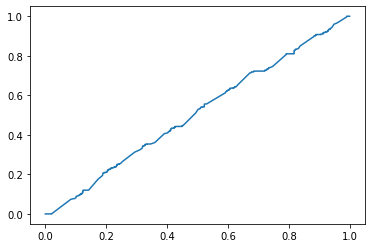

In [17]:
attack = ConfidenceVectorAttack(target_model, (train_images, train_labels), (attacker_images, attacker_labels), f_shadow, 
                                n_shadows=N_SHADOWS, D_shadow_size=D_SHADOW_SIZE)
attack.perform_attack()
attack.evaluate_attack()

# Label Only Attack
Perform the attack, evaluate it and compare it with the *condifence vector* MIA.

Preparing shadow batch of size 990
Done!
Preparing shadow batch of size 990
Done!
Preparing shadow batch of size 990
Done!
Preparing shadow batch of size 990
Done!
Preparing shadow batch of size 990
Done!
class-1 acc: 0.5620437860488892
class-2 acc: 0.5141242742538452
class-3 acc: 0.559440553188324
class-4 acc: 0.4727272689342499
class-5 acc: 0.557692289352417
class-6 acc: 0.5845070481300354
class-7 acc: 0.5379310250282288
class-8 acc: 0.5102040767669678
class-9 acc: 0.5155279636383057
class-10 acc: 0.584269642829895
              precision    recall  f1-score   support

         0.0       0.68      0.14      0.24       800
         1.0       0.52      0.93      0.67       800

    accuracy                           0.54      1600
   macro avg       0.60      0.54      0.45      1600
weighted avg       0.60      0.54      0.45      1600

AUC: 0.5459328125


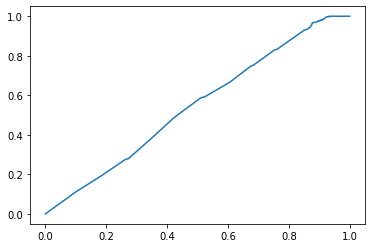

In [13]:
label_only_attack = LabelOnlyAttack(target_model, (train_images, train_labels), (attacker_images, attacker_labels), 
                                    rotates=3, translates=1, shadow_creator=f_shadow, 
                                n_shadows=N_SHADOWS, D_shadow_size=D_SHADOW_SIZE)
label_only_attack.perform_attack()
label_only_attack.evaluate_attack()

## Attack Comparison Results

//TODO:

# Extras
Following we will add some appendices to prove assumptions of the attacks and test some new stuff


## Check target model's behaviour in perturbed images

In [18]:
def study_perturbations(model, X, y, rs, ts):
  diffs = []
  y_pred = target_predict(model, X)    
  for c in range(10):
    #  given class acquire the changes in perturbed input instances given the model
    idx = y_pred[:, 0] == c
    X_c = X[idx]
    y_pred_c = y_pred[idx]
    perturbed_labels = augmented_queries(model, X_c, y_pred_c, rs, ts)
    # Now we have to count how many labels diverge from the predicted label
    diff = len(perturbed_labels.reshape(-1)) - sum(perturbed_labels.reshape(-1)) # the labels are binary where 1 == y_pred = y_perturbed, otherwise 0
    diffs.append(int(100 * diff/len(perturbed_labels.reshape(-1)))) # append the percentage of changes in the class sample
    
  return diffs 

In [19]:
N_SAMPLES = 100
r = 3
d = 1
train_idx = np.random.choice(range(train_images.shape[0]), N_SAMPLES, replace=False)
test_idx = np.random.choice(range(attacker_images.shape[0]), N_SAMPLES, replace=False)

 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%')]

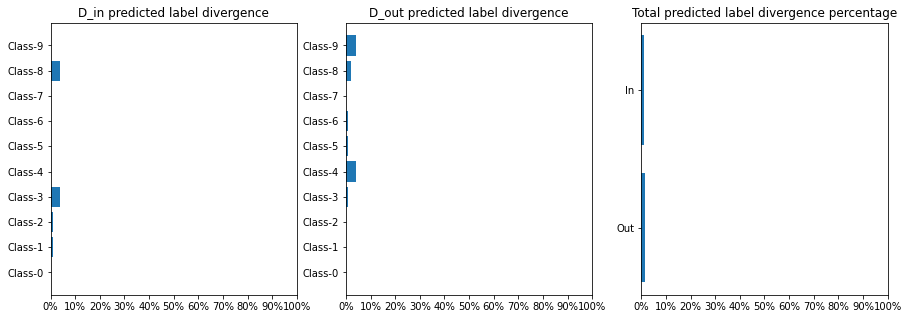

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# tests in D_in
diffs_per_class_D_in = study_perturbations(target_model, train_images[train_idx], train_labels[train_idx], r, d) 
total_diffs_in = sum(diffs_per_class_D_in)/10
axes[0].set_title('D_in predicted label divergence');
axes[0].barh(list(range(10)), diffs_per_class_D_in, tick_label=[f'Class-{i}' for i in range(10)])

# tests in D_out  
diffs_per_class_D_out= study_perturbations(target_model,attacker_images[test_idx],attacker_labels[test_idx], r, d)
total_diffs_out = sum(diffs_per_class_D_out)/10
axes[1].set_title('D_out predicted label divergence');
axes[1].barh(list(range(10)), diffs_per_class_D_out, tick_label=[f'Class-{i}' for i in range(10)])

axes[2].set_title('Total predicted label divergence percentage');
axes[2].barh([1, 0], [total_diffs_in, total_diffs_out], tick_label=['In', 'Out'])

plt.setp(axes, xticks=range(0, 101, 10), xticklabels=[f'{i}%' for i in range(0, 101, 10)])

We can conclude that $x \in D_{target}$ are more robust to perturbations, than any other instance not in target's training dataset. Nevertheless, whether the model is overfitted or not plays an important role to this training feature, meaning that the more overfit the model is the easier it gets to infer membership of tested instances. 

## Attack a perturbation trained model

- We will apply augmentations to the dataset and re-train the target model.
- The attacker **does not** know our augmentation settings, so he will train with a normal dataset of zero augmentations
- We want to measure the quality of the attack when the target tries to defend MIAs by adding perturbed images of data samples 

In [21]:
# We will defend against the same rotations and translations that the attack models uses (worst case for the attacker)
rotates = create_rotates(r)
translates = create_translates(d)

X_train_aug = train_images
X_eval_aug = eval_images
y_train_aug = np.concatenate(tuple([train_labels] + [train_labels for rot in rotates] + [train_labels for tra in translates]))
y_eval_aug = np.concatenate(tuple([eval_labels] + [eval_labels for rot in rotates] + [eval_labels for tra in translates]))



for rot in rotates:
  aug_x = apply_augment(train_images, rot, 'r')
  X_train_aug = np.concatenate((X_train_aug,aug_x))
  aug_x = apply_augment(eval_images, rot, 'r')
  X_eval_aug = np.concatenate((X_eval_aug,aug_x))

for tra in translates:
  aug_x = apply_augment(train_images, tra, 'd')
  X_train_aug = np.concatenate((X_train_aug,aug_x))
  aug_x = apply_augment(eval_images, tra, 'd')
  X_eval_aug = np.concatenate((X_eval_aug ,aug_x))


In [22]:

with tf.device('/gpu:0'):
  X_train_aug = tf.convert_to_tensor(X_train_aug)
  y_train_aug = tf.convert_to_tensor(y_train_aug)
  X_eval_aug = tf.convert_to_tensor(X_eval_aug)
  y_eval_aug = tf.convert_to_tensor(y_eval_aug)
  target_model = f_target(X_train_aug, y_train_aug, X_eval_aug, y_eval_aug, epochs=10) 

Epoch 1/10
325/325 [==============================] - 5s 14ms/step - loss: 0.2759 - accuracy: 0.9107 - val_loss: 0.1472 - val_accuracy: 0.9531
Epoch 2/10
325/325 [==============================] - 4s 14ms/step - loss: 0.0438 - accuracy: 0.9862 - val_loss: 0.2615 - val_accuracy: 0.9219
Epoch 3/10
325/325 [==============================] - 5s 15ms/step - loss: 0.0352 - accuracy: 0.9889 - val_loss: 0.2048 - val_accuracy: 0.9623
Epoch 4/10
325/325 [==============================] - 5s 15ms/step - loss: 0.0292 - accuracy: 0.9917 - val_loss: 0.1154 - val_accuracy: 0.9746
Epoch 5/10
325/325 [==============================] - 5s 15ms/step - loss: 0.0034 - accuracy: 0.9985 - val_loss: 0.3506 - val_accuracy: 0.9435
Epoch 6/10
325/325 [==============================] - 4s 14ms/step - loss: 0.0321 - accuracy: 0.9913 - val_loss: 0.1645 - val_accuracy: 0.9677
Epoch 7/10
325/325 [==============================] - 5s 15ms/step - loss: 0.0267 - accuracy: 0.9928 - val_loss: 0.0838 - val_accuracy: 0.9785

The model is quite overfitted so now all that is left is to evaluate the attack model we created before on the newly trained and "defended" target model with perturbations in the train dataset.

Preparing shadow batch of size 990
Done!
Preparing shadow batch of size 990
Done!
Preparing shadow batch of size 990
Done!
Preparing shadow batch of size 990
Done!
Preparing shadow batch of size 990
Done!
class-1 acc: 0.49643945693969727
class-2 acc: 0.5342293381690979
class-3 acc: 0.5283911824226379
class-4 acc: 0.509661853313446
class-5 acc: 0.5482434630393982
class-6 acc: 0.5550435185432434
class-7 acc: 0.4785462021827698
class-8 acc: 0.5597109794616699
class-9 acc: 0.5289255976676941
class-10 acc: 0.5748770833015442
              precision    recall  f1-score   support

         0.0       0.74      0.10      0.17     10400
         1.0       0.52      0.97      0.67     10400

    accuracy                           0.53     20800
   macro avg       0.63      0.53      0.42     20800
weighted avg       0.63      0.53      0.42     20800

AUC: 0.5480921782544379


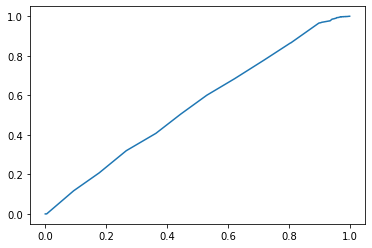

In [25]:
label_only_attack = LabelOnlyAttack(target_model, (X_train_aug.numpy(), y_train_aug.numpy()), (attacker_images, attacker_labels), 
                                    rotates=3, translates=1, shadow_creator=f_shadow, 
                                n_shadows=N_SHADOWS, D_shadow_size=D_SHADOW_SIZE)
label_only_attack.perform_attack()
label_only_attack.evaluate_attack()

### Conclusion

To conclude if the model is more vulnerable, we must meassure the label divergence percentage in the adjusted-to-augmentations model.

 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%')]

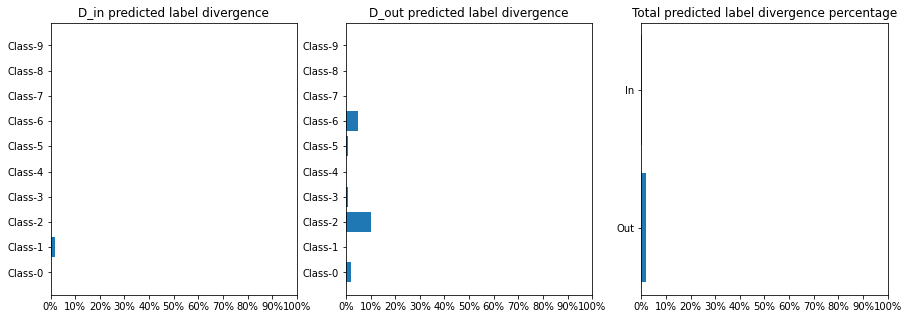

In [26]:
# test it onthe same data as we tested the non-adjusted to augmentation model
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# tests in D_in
diffs_per_class_D_in = study_perturbations(target_model, train_images[train_idx], train_labels[train_idx], r, d) 
total_diffs_in = sum(diffs_per_class_D_in)/10
axes[0].set_title('D_in predicted label divergence');
axes[0].barh(list(range(10)), diffs_per_class_D_in, tick_label=[f'Class-{i}' for i in range(10)])

# tests in D_out  
diffs_per_class_D_out= study_perturbations(target_model,attacker_images[test_idx],attacker_labels[test_idx], r, d)
total_diffs_out = sum(diffs_per_class_D_out)/10
axes[1].set_title('D_out predicted label divergence');
axes[1].barh(list(range(10)), diffs_per_class_D_out, tick_label=[f'Class-{i}' for i in range(10)])

axes[2].set_title('Total predicted label divergence percentage');
axes[2].barh([1, 0], [total_diffs_in, total_diffs_out], tick_label=['In', 'Out'])

plt.setp(axes, xticks=range(0, 101, 10), xticklabels=[f'{i}%' for i in range(0, 101, 10)])